In [ ]:
!pip install evaluate bert_score rouge_score matplotlib

In [1]:
# 导入必要的库
from unsloth import FastVisionModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# 检查模型目录内容
import os

model_path = "/root/autodl-tmp/models/unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"
print("📁 检查模型文件...")

required_files = [
    "config.json",
    "model.safetensors",  # 或者 pytorch_model.bin
    "tokenizer.json",
    "tokenizer_config.json",
    "special_tokens_map.json"
]

for file in required_files:
    file_path = os.path.join(model_path, file)
    if os.path.exists(file_path):
        print(f"✅ {file} 存在")
    else:
        print(f"❌ {file} 缺失")

# 列出所有文件看看
print("\n📋 目录内容:")
for item in os.listdir(model_path):
    print(f"  - {item}")

In [2]:
import os
# 强制离线模式
os.environ['TRANSFORMERS_OFFLINE'] = '1'
os.environ['HF_HUB_OFFLINE'] = '1'
print("🔌 强制离线模式已启用")

# 加载模型和分词器
model, tokenizer = FastVisionModel.from_pretrained(
    model_name="/root/autodl-tmp/models/unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit", # 指明要去加载的模型在本地的路径
    load_in_4bit=True, # 使用 4bit 量化减少内存的使用。 默认是 False，则会使用 16bit 训练
    use_gradient_checkpointing="unsloth", # 设置为 True 或者 设置为 "unsloth" 支持更长的上下文
    local_files_only=True  # 明确指定只使用本地文件
)
print("模型加载完成")

🔌 强制离线模式已启用
==((====))==  Unsloth 2025.11.3: Fast Qwen2_5_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA GeForce RTX 5090. Num GPUs = 1. Max memory: 31.357 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
模型加载完成


##### 现在添加 LoRA 适配器，用于参数高效微调 PEFT，使得我们在高效参数微调的时候，只去调整大概整体模型参数量的 1%
##### 支持仅微调模型的视觉部分或者语言模型部分。或者我们也可以选择两者都去调整，还可以选择微调注意力机制相关的参数或者全连接层MLP相关的参数

In [3]:
model = FastVisionModel.get_peft_model(
    model,

    # 首先整体上设置多模态大模型中哪些层去进行LoRA微调
    finetune_vision_layers=False, # 是否微调视觉相关层
    finetune_language_layers=True, # 是否微调语言模型相关的层
    finetune_attention_modules=True, # 是否微调注意力相关层
    finetune_mlp_modules=True, # 是否微调 MLP 层，影响验证集准确率

    # LoRA 相关核心参数
    r = 16, # rank值，越大调整的参数就会越多，当然也会越准；但容易过拟合
    lora_alpha = 32, # 推荐至少 alpha==r，影响训练过程中收敛的速度和效果
    lora_dropout = 0, # dropout ratio 用于放置过拟合的手段
    bias = "none", # 截距项，是否添加偏置项

    # 配置其它的一些超参数
    random_state = 32, # 第32组——随机种子
    use_rslora = False, # 如果设置成True，它就会去使用 rank stabilized LoRA
    loftq_config = None, # 关于 LoftQ 配置，用于量化
    # target_modules = "all-linear", # 可选项，可以指导需要应用LoRA的具体模块是哪些
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


### 加载数据

###### 该数据集包含医疗图像和相关诊断描述信息，每幅图像配有专家撰写的说明文字；图像是有一些X光片、CT扫描和超声图像构成的。目标是通过 VLM 进行微调，使得我们微调之后的模型成为医疗专业人员实用分析工具。

In [4]:
from datasets import load_dataset

dataset = load_dataset("./dataSet/", split="train")
split_dataset = dataset.train_test_split(test_size=0.1, seed=32)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(eval_dataset)}")

训练集大小: 1780
验证集大小: 198


In [5]:
train_dataset

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 1780
})

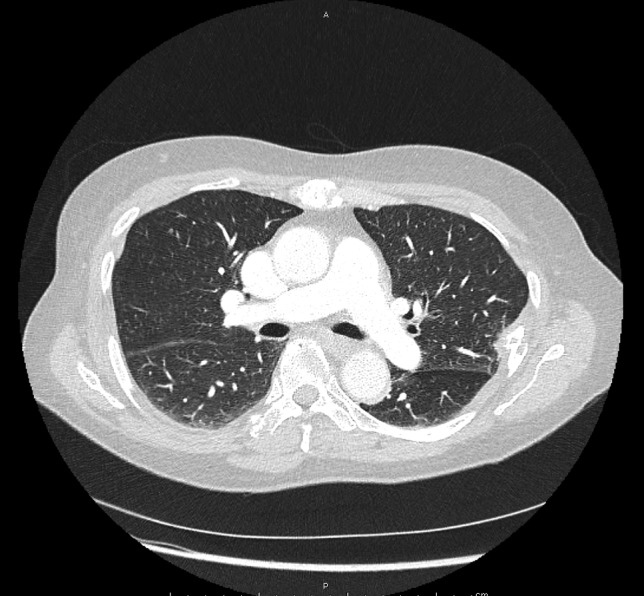

In [6]:
train_dataset[0]['image']

In [7]:
train_dataset[0]['caption']

'CT pulmonary angiogram performed in February 2016 revealed near-complete resolution of pulmonary nodules, pleural thickening and pleural effusion.'

In [8]:
eval_dataset

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 198
})

In [ ]:
eval_dataset[0]['image']

In [ ]:
eval_dataset[0]['caption']

In [ ]:
# 视觉大模型，针对我们当前的数据集，格式/模板

[
    {
        "role": "user",
        "content": [{"type":"text", "text": instruction}, {"type":"image", "image": image}]
    },
    {
        "role": "assistant",
        "content": [{"type":"text", "text": answer}]
    }

]

##### 首先我们讲编写一个自定义的指令，要求 VLM 成为一名专业的放射科医生。请注意，除了一条指令之外，事实上我们还可以添加多条指令，使其成为动态对话。

In [9]:
instruction = "你是一名专业的放射科医生。请准确描述你在图片中看到的内容。"

def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [{"type":"text", "text": instruction}, {"type":"image", "image": sample['image']}]
        },
        {
            "role": "assistant",
            "content": [{"type":"text", "text": sample['caption']}]
        }
    ]
    return {"messages": conversation}

In [10]:
# converted_dataset = [convert_to_conversation(sample) for sample in dataset]

converted_train_dataset = [convert_to_conversation(sample) for sample in train_dataset]
converted_eval_dataset = [convert_to_conversation(sample) for sample in eval_dataset]

In [11]:
converted_train_dataset[0]
converted_eval_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': '你是一名专业的放射科医生。请准确描述你在图片中看到的内容。'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=298x500>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Periprosthetic atypical femoral fractures under the cement mantle. The lateral cortex is thickened and the fracture line is short oblique. This patient sustained minimal trauma when the fracture took place.'}]}]}

##### 在进行模型微调之前，让我们先来看看某一个样本输入模型，对应输出是什么

In [12]:
FastVisionModel.for_inference(model)  # 把模型切换到推理模式

image = train_dataset[0]["image"]
instruction = "你是一名专业的放射科医生。请准确描述你在图片中看到的内容。"

messages = [
    {
        "role": "user", "content":[
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]
    }
]

# add_generation_prompt 设置为True相当于是添加 assistant 信息
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

In [13]:
input_text

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>你是一名专业的放射科医生。请准确描述你在图片中看到的内容。<|im_end|>\n<|im_start|>assistant\n'

In [14]:
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False, # 前面已经是应用了apply_chat_template()已经添加了这些特殊符号
    return_tensors = 'pt',
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True) # skip_prompt设置为True就是返回结果不包括输入的提示词
# min_p 设置了一个最低值，只有达到这个值的token才会被考虑。这个值会根据最高概率token的置信度而变化。
# 如果设置为0.1，那意味着它只会允许概率至少是最大概率token的1/10，如果设置为0.05，则会允许至少是最大概率token的1/20的token。
# temperature 温度是一个用于控制AI生成文本的创造力/多样性水平的参数。
# 每一个时刻输出的tokens可选项会有一个概率分布，温度越高，创造力就变低
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=512, use_cache=True, temperature=1.5, min_p=0.1)

这张CT图像显示了一个胸部横截面的图像，图像中可以看到胸部的不同结构。以下是对这张CT图像内容的具体描述：

1. **心脏**：在图像中央，可以清晰地看到一个圆形、明亮的部分，这代表心脏及其结构。心脏周围的较暗区域代表胸腔和肺组织。

2. **肺部**：图像两侧展示了肺部结构。肺部是黑色的，并且含有许多细微的小点状结构，这些是肺内的细支气管和毛细血管，正常情况下在CT上呈现出这个特征性的灰白色分布。

3. **脊柱**：脊柱位于图像的中心偏上部，在胸椎水平上清晰可见。它是白色的，类似于骨骼，在胸部横截面上可以看到它的弧度形状。

4. **胸膜腔**：在心脏周围可以看到一些小片状的白色，这是胸膜腔，正常情况下没有液体在里面。

5. **软组织细节**：肺部和其他部位之间的界限清晰可见，表示呼吸系统、循环系统与其他体腔间结构之间存在的良好对比度。

总体上，这张CT图像显示的是一个健康人的胸部横截面图像，无明显异常表现。需要结合患者的病史及其他检查结果进行综合分析与诊断。<|im_end|>


# 训练模型

In [15]:
# 导入必要模块

from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig


In [ ]:
import transformers

# 存储loss数据和学习率
losses = []
learning_rates = []
steps = []

# 自定义回调类来记录loss和学习率
class LossAndLrCallback(transformers.TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            current_step = state.global_step
            current_loss = logs['loss']
            losses.append(current_loss)
            steps.append(current_step)
            
            # 尝试获取当前学习率
            current_lr = self._get_current_lr(args, state)
            learning_rates.append(current_lr)
            
            print(f"Step {current_step}: Loss = {current_loss:.4f}, LR = {current_lr:.2e}")
    
    def _get_current_lr(self, args, state):
        """获取当前学习率"""
        # 方法1: 尝试从logs中获取
        if hasattr(self, 'logs') and 'learning_rate' in self.logs:
            return self.logs['learning_rate']
        
        # 方法2: 尝试从优化器参数中获取
        try:
            if hasattr(state, 'optimizer') and state.optimizer is not None:
                for param_group in state.optimizer.param_groups:
                    if 'lr' in param_group:
                        return param_group['lr']
        except:
            pass
        
        # 方法3: 根据学习率调度器计算
        try:
            if state.global_step < args.warmup_steps:
                # 热身阶段
                return args.learning_rate * (state.global_step / max(1, args.warmup_steps))
            else:
                # 线性衰减
                progress = (state.global_step - args.warmup_steps) / max(1, args.max_steps - args.warmup_steps)
                return args.learning_rate * max(0.0, 1.0 - progress)
        except:
            # 方法4: 返回固定学习率
            return args.learning_rate

In [16]:
# [新 Cell] 定义可视化回调函数
import transformers
import matplotlib.pyplot as plt
import os

class PlotLossCallback(transformers.TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.train_step = []
        self.val_loss = []
        self.val_step = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            # 记录训练 Loss
            if "loss" in logs:
                self.train_loss.append(logs["loss"])
                self.train_step.append(state.global_step)
            
            # 记录验证 Loss (eval_loss)
            if "eval_loss" in logs:
                self.val_loss.append(logs["eval_loss"])
                self.val_step.append(state.global_step)
                print(f"Step {state.global_step}: Val Loss = {logs['eval_loss']:.4f}")
                # 每次验证时更新图表
                self.plot_losses()

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_step, self.train_loss, label="Training Loss", alpha=0.6)
        if self.val_loss:
            plt.plot(self.val_step, self.val_loss, label="Validation Loss", marker='o', linewidth=2)
        
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training & Validation Loss Curve")
        plt.legend()
        plt.grid(True, alpha=0.3)
        # 保存图片，您可以在左侧文件浏览器查看
        plt.savefig("loss_curve.png")
        plt.close()

In [17]:
FastVisionModel.for_training(model)  # 切换训练模式！

# 配置训练器
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # 必须要设置的
    train_dataset = converted_train_dataset,
    eval_dataset = converted_eval_dataset,
    callbacks=[PlotLossCallback()],
    
    args = SFTConfig(
        # 基础训练的相关参数
        per_device_train_batch_size = 2, # 对应每个显卡的批次包含的样本数
        gradient_accumulation_steps = 4, # 梯度累积步数，目的就是节省显存空间，用时间换空间了
        # max_steps = 800,                 # 最大训练次数，当我们给定 max_steps后，它会覆盖 num_train_epochs
        num_train_epochs = 1,          # 完整训练一次，把训练样本交给模型学习一遍

        do_eval = True,                 # 开启评估
        eval_strategy = "steps",        # 按步数评估
        eval_steps = 20,                
        per_device_eval_batch_size = 4, # 验证时的 Batch Size
        metric_for_best_model = "eval_loss", # 根据验证Loss选择最佳模型
        load_best_model_at_end = True,
        # ------------------
        # 优化器、学习率相关参数设置
        learning_rate = 2e-4, # 学习率
        warmup_steps = 5,   # 预热步数/预热迭代次数
        lr_scheduler_type = "linear", # 线性学习率调整器
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),

        # Adam 优化器本身结合动量和自适应学习率，能够适应稀疏梯度，在许多任务上表现都很出色。
        # AdamW 8-bit 是 AdamW 优化器的一种低精度变体，目的降低内存消耗和计算成本。
        # 低精度计算：标准的是 32bit 浮点数运算，每个数值占用32位，8bit是不是相当于仅是原来的1/4，这种低精度训练方法特别适合内存受限的环境去训练大模型，
        # 例如在边缘设备上进行训练，或者需要训练特别大的大模型的时候。
        optim = "adamw_8bit", # 使用 8bit AdamW 优化器来调整参数
        weight_decay = 0.01,  # 权重衰减，其实本质上是和正则项有关系的 L1/L2

        output_dir="./output",
        logging_steps=20,  
        report_to=None,   # 禁用其他记录器
        save_steps=20,
    )
)

Unsloth: Model does not have a default image size - using 512


In [18]:
# 显存当前内存信息
gpu_stats = torch.cuda.get_device_properties(0)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memroy = {max_memory} GB.")
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 5090. Max memroy = 31.357 GB.
7.33 GB of memory reserved.


In [20]:
inputs

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         15165

In [21]:
tokenizer.batch_decode(inputs['input_ids'])

['<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image

In [22]:
inputs['pixel_values'].size()

torch.Size([1932, 1176])

In [23]:
import time


from unsloth import is_bfloat16_supported
from transformers import TrainingArguments
import time


start_time = time.time()
print("开始模型训练...")

trainer_stats = trainer.train()

end_time = time.time()
training_time = end_time - start_time
print(f"训练成功完成! 总耗时: {training_time:.2f}秒")


The model is already on multiple devices. Skipping the move to device specified in `args`.


开始模型训练...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,780 | Num Epochs = 1 | Total steps = 223
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176 of 8,332,536,832 (0.48% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,2.693200,1.077676
40,1.073200,1.065649
60,1.050600,1.055632
80,1.013600,1.054050
100,1.060900,1.052363
120,1.091700,1.048359
140,1.041200,1.047216
160,1.026900,1.047166
180,1.050000,1.045949
200,1.051600,1.045391


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step 20: Val Loss = 1.0777
Step 40: Val Loss = 1.0656
Step 60: Val Loss = 1.0556
Step 80: Val Loss = 1.0541
Step 100: Val Loss = 1.0524
Step 120: Val Loss = 1.0484
Step 140: Val Loss = 1.0472
Step 160: Val Loss = 1.0472
Step 180: Val Loss = 1.0459
Step 200: Val Loss = 1.0454
Step 220: Val Loss = 1.0447
训练成功完成! 总耗时: 721.90秒


### 运行模型，设置指令和输入，将输出留空

In [28]:
FastVisionModel.for_inference(model)  # 把模型切换到推理模式

image = train_dataset[0]["image"]
instruction = "你是一名专业的放射科医生。请准确描述你在图片中看到的内容。"

messages = [
    {
        "role": "user", "content":[
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]
    }
]

# add_generation_prompt 设置为True相当于是添加 assistant 信息
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False, # 前面已经是应用了apply_chat_template()已经添加了这些特殊符号
    return_tensors = 'pt',
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True) # skip_prompt设置为True就是返回结果不包括输入的提示词
# min_p 设置了一个最低值，只有达到这个值的token才会被考虑。这个值会根据最高概率token的置信度而变化。
# 如果设置为0.1，那意味着它只会允许概率至少是最大概率token的1/10，如果设置为0.05，则会允许至少是最大概率token的1/20的token。
# temperature 温度是一个用于控制AI生成文本的创造力/多样性水平的参数。
# 每一个时刻输出的tokens可选项会有一个概率分布，温度越高，创造力就变低
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=512, use_cache=True, temperature=1.5, min_p=0.1)

CT chest shows cardiomegaly with pericardial effusion, and diffuse interstitial pattern.<|im_end|>


In [29]:
inputs

{'input_ids': tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198, 151652, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         15165

In [30]:
tokenizer.batch_decode(inputs['input_ids'])

['<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image

In [31]:
inputs['pixel_values'].size()  # 657x442 图像的宽是 657 图像的高 442

torch.Size([1932, 1176])

In [32]:
# 模型保存到本地，LoRA

model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")

[]

In [33]:
# 保存合并的模型
model.save_pretrained_merged("merged_model", tokenizer, save_method="merged_4bit_forced")

Detected local model directory: /root/autodl-tmp/models/unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit
Unsloth: Merging LoRA weights into 4bit model...


/root/miniconda3/lib/python3.12/site-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Unsloth: Merging finished.
Unsloth: Found skipped modules: ['model.visual.blocks.0.attn.qkv', 'model.visual.blocks.0.attn.proj', 'model.visual.blocks.0.mlp.gate_proj', 'model.visual.blocks.0.mlp.up_proj', 'model.visual.blocks.0.mlp.down_proj', 'model.visual.blocks.1.attn.qkv', 'model.visual.blocks.1.attn.proj', 'model.visual.blocks.1.mlp.gate_proj', 'model.visual.blocks.1.mlp.up_proj', 'model.visual.blocks.1.mlp.down_proj', 'model.visual.blocks.2.attn.qkv', 'model.visual.blocks.2.attn.proj', 'model.visual.blocks.2.mlp.gate_proj', 'model.visual.blocks.2.mlp.up_proj', 'model.visual.blocks.2.mlp.down_proj', 'model.visual.blocks.3.attn.qkv', 'model.visual.blocks.3.attn.proj', 'model.visual.blocks.3.mlp.gate_proj', 'model.visual.blocks.3.mlp.up_proj', 'model.visual.blocks.3.mlp.down_proj', 'model.visual.blocks.4.attn.qkv', 'model.visual.blocks.4.attn.proj', 'model.visual.blocks.4.mlp.gate_proj', 'model.visual.blocks.4.mlp.up_proj', 'model.visual.blocks.4.mlp.down_proj', 'model.visual.blocks